# Recap

Data comes in different formats: `.fa.gz` for genomes, `.fastq.gz` for raw reads, `.bam` for mapped reads, `.vcf.gz` for genotype calls.

* Format means that specific elements are expected in a specific order.
* Reference genomes have different versions - always know which one you use!

Command line tools to filter, specialised tools for such data: `samtools` for mapped reads, `gatk MarkDuplicates` for filtering, `gatk HaplotypeCaller` for genotype calling.

Variant calls can be for all basepairs, for only SNPs, or in a condensed genome-wide format ("gvcf") - but all based on the convention of the `VCF` file format. `VCF` files can be for many individuals.

One important toolkit to work with the files is `bcftools`.

`bcftools concat` to add rows (genomic positions for the same individuals), `bcftools merge` to add columns (individuals for the same positions)

`bcftools view -r ` to obtain regions

`bcftools view -S ` to obtain individuals

`bcftools view -a ` to trim alleles

`bcftools filter` to perform a lot of filtering

Now for something slightly different. We have looked at sequencing data, and often we obtain numbers. It is always a good idea to visualise some of this. How do you do this from the command line (assuming you are not on your laptop but a remote server)?


# Some data visualisation

## Proportion of sequencing reads

Assume you store information on your raw data in files. You have 20 sequencing experiments, and obtain values for

* raw sequencing reads
* reads after adapter removal
* reads mapped
* reads with sufficient quality (e.g. -m 35 -q 30)
* reads after duplicate removal

These proportions would tell you if something went wrong - and where it went wrong. A problem in library preparation may lead to high adapter abundance. DNA degradation may lead to small number of reads mapped, short reads or reads of low quality. PCR overamplification may lead to high numbers of duplicates, etc. It might be useful to look at this visually to check what is going on.

Here is a table with the values: `~/bioinfo-course/notebooks/12_seq_viz/data/seqdata_summary.tsv`

For visualization, working in R is nice. RStudio does unfortunately not run on the server using the current platform, so we may work on the R command line interface for this course.

This also means plots are not showing up immediately, you need to save them.

However, if you have RStudio on your computer, you may download the material and use it there.

```
R --vanilla
```

Now we load the table:

```
seqdata<-read.table("~/bioinfo-course/notebooks/12_seq_viz/data/seqdata_summaries.tsv", sep="\t",header=T)
```

* A first thing is to get the proportions of reads retained, not calculating one by one, but at once.

```
seqdata[,-1]/seqdata[,2]
```

* Maybe easier to read as percentage?

```
round(seqdata[,-1]/seqdata[,2]*100,1)
```

As you may see, there are problematic samples around, where you lose a large proportion of reads towards the end of the tests. Some might be ancient DNA, some might be degraded, some might be overamplified with a PCR.

Let's visualise it! An easy way with base R would be a barplot, showing the loss of data in each sample. For that, you need to turn it into a matrix, exchange columns and rows.

* Let's do it!

```
bdata<-t(as.matrix(seqdata[,-1]))

png("seq_reads.png",800,400)
barplot(bdata,beside=T,names.arg=seqdata[,1])
dev.off()
```

How about a legend?

```
png("seq_reads.png",800,400)
barplot(bdata,beside=T,names.arg=seqdata[,1],legend.text=colnames(seqdata)[-1])
dev.off()
```

Ok, this looks ugly... We may need to adapt the plot a little bit to give it enough space (`ylim`), and change the legend a bit (`args.legend` for making it horizontal and located in the middle):

```
png("seq_reads.png",800,400)
barplot(bdata,beside=T,names.arg=seqdata[,1],legend.text=colnames(seqdata)[-1],args.legend=list(x="top",horiz=T),ylim=c(0,7200000))
dev.off()
```

As you can see, there are samples that visually stick out at different points. Assume this is a screening, where you want to know for a couple of samples how good they work for sequencing, you can choose which ones to continue with! This is very nice!

* From what we know about aDNA, they tend to lose a lot of data at each step, this might be the case for two samples.

* One sample has most data removed as unmapped - likely a sample with very little human DNA.

* One sample has a sharp drop when removing low quality mappings - this might be due to ultra-short reads?

* One sample loses most of the data when removing duplicates - this could be the case after over-amplification in a PCR experiment.


## Coverage distribution

Let's take the coverage from the chr18 data from a previous challenge! This is the `bcftools stats` output, and again we can use `awk` to subset the information which we need, the sequencing depths (`DP`).

```
awk '$1=="DP"' ~/bioinfo-course/notebooks/12_seq_viz/data/chr18stats.txt > ~/test/DP.txt
```

Note that you operate here in `bash` to run certain analyses, and in `R` to visualise. *These are different environments with different structures and commands!* You need to be aware of this, and may use two parallel Terminals.

* Reading in the table the same way:

```
covdata<-read.table("~/test/DP.txt", sep="\t",header=T)

head(covdata)
```

* Oh no, another problem - the first line is actual data, not a header! What to do?

Here, we only need to care about the third and the sixth column, i.e. the depth and the number of sites at each depth. We can do a line plot from this, right?

```
png("read_depth.png",800,400)
plot(x=covdata[,3],y=covdata[,6],type="l")
dev.off()
```

Ok, not nice, because almost no positions are at depth >20.

```
png("read_depth.png",800,400)
covdata2<-covdata[which(as.numeric(covdata[,3])<=20),]
plot(x=covdata2[,3],y=covdata2[,6],type="l")
dev.off()
```

Much better! You get a feeling about the sequencing depth distribution. It looks kind of normal, with a tail towards higher coverage, and centered around 7-fold.

Finally, let's make the plot a bit nicer! I would like to add:

* dots for each datapoint, a thick line between them
* blue color
* proper axis labels
* a nice title

```
png("read_depth.png",800,400)
plot(x=covdata2[,3],y=covdata2[,6],
    type="o", lwd=2,pch=19,
    col="blue",
    xlab="Coverage",ylab="Frequency",
    main="Coverage distribution for chr18" )
dev.off()
```

This looks like a nice coverage plot now!

Now, we can add the coverage distribution of another sample, as provided here:

```
# in BASH

awk '$1=="DP"' ~/bioinfo-course/notebooks/12_seq_viz/data/bcftoolsstats_nw.txt > ~/test/DP2.txt
```

```
# in R

covnew<-read.table("~/test/DP2.txt", sep="\t",header=F)
covnew2<-covnew[which(as.numeric(covnew[,3])<=20),]

png("read_depth_2samp.png",800,400)

plot(x=covdata2[,3],y=covdata2[,6],
    type="o", lwd=2,pch=19,
    col="blue",
    xlab="Coverage",ylab="Frequency",
    main="Coverage distribution for chr18" )
par(new=T)
plot(x=covnew2[,3],y=covnew2[,6],
    type="o", lwd=2,pch=19,
    col="orange",
    xlab="Coverage",ylab="Frequency",
    main="Coverage distribution for chr18" ) 
dev.off()
```

Does this work? In principle, yes, but there are problems:

* The distribution is truncated for the second sample.

```
covnew2<-covnew[which(as.numeric(covnew[,3])<=35),]
covdata2<-covdata[which(as.numeric(covdata[,3])<=35),]
```

* Scales are different on both axes!

```
xlims=c(0,35)
ylims=c(0,max(c(covnew2[,6],covdata2[,6])))
```

* And everything is plotted twice.

```
png("read_depth_2samp.png",800,400)

plot(x=covdata2[,3],y=covdata2[,6],
    type="o", lwd=2,pch=19,
    col="blue",
    xlab="Coverage",ylab="Frequency",
    main="Coverage distribution for chr18",
    xlim=xlims,ylim=ylims )
par(new=T)
plot(x=covnew2[,3],y=covnew2[,6],
    type="o", lwd=2,pch=19,
    col="orange",
    xlab="",ylab="",
    main="",
    xlim=xlims,ylim=ylims,
    axes=F,bty="n")
    
dev.off()
```

Ok, better in many regards. However, as you can see there are many more datapoints for the other sample, and actually we would like to be able to really compare the distribtions rather than the raw values.

* So, let's normalize by the number of observations!

```

covdata2$normed<-covdata2[,6]/sum(covdata2[,6])
covnew2$normed<-covnew2[,6]/sum(covnew2[,6])
ylims=c(0,max(c(covnew2$normed,covdata2$normed)))

png("read_depth_2samp.png",800,400)

plot(x=covdata2[,3],y=covdata2$normed,
    type="o", lwd=2,pch=19,
    col="blue",
    xlab="Coverage",ylab="Frequency",
    main="Coverage distribution for chr18",
    xlim=xlims,ylim=ylims )
par(new=T)
plot(x=covnew2[,3],y=covnew2$normed,
    type="o", lwd=2,pch=19,
    col="orange",
    xlab="",ylab="",
    main="",
    xlim=xlims,ylim=ylims,
    axes=F,bty="n" ) 
    
dev.off()
```

Now, this is what you would want to have for such a comparison!


## Heterozygosity

Now, we may go back to the 1000 genomes VCF file we used earlier, and obtain heterozygous positions. For this, we can use `bcftools`. With `-s` samples are selected, and the rows starting on `PSC` are per-sample-counts. This table could be the raw table.

```
# in BASH
bcftools stats -s - ALL.chr18.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz | grep "^PSC" -B 1 > hets.txt
```

Keep in mind that, this as well as many other things can be solved by multiple possible strategies. In this case, I show one version, but there are alternatives.

If you inspect the file, you will see that there is one line per sample, with several columns containing the statistics. Column 6 is the number of Hets.

* Let's have some look at the data!

```
# in R

hets<-read.table("~/test/hets.txt", sep="\t",header=T,comment.char="")


png("hets_histogram.png",600,600)
hist(hets[,6])
dev.off()
```

* Is there a relationship between homozygous alternative (1/1) and heterozygous (0/1) sites?

```
png("hets_vs_homALT.png",600,600)
plot(hets[,5],hets[,6])
dev.off()

cor.test(hets[,5],hets[,6])
```

* Now, I would like to stratify this by population groups. For this, we need to load the metadata and do some merging. Unfortunately, when creating this file, the authors messed with empty columns, so we need to tell `R` to ignore this. Then we merge, taking only the sample ID and heterozygous call columns.


```
meta<-read.table("~/test/integrated_call_samples_v3.20130502.ALL.panel", sep="\t",header=T,fill=T)

head(meta)

hetmet<-merge(hets[,c(3,6)],meta,by.x=1,by.y=1)

head(hetmet)
```

* Just having some fun with statistics in R:

```
mean(hetmet[which(hetmet$pop=="IBS"),2])
mean(hetmet[which(hetmet$pop=="FIN"),2])
wilcox.test(hetmet[which(hetmet$pop=="IBS"),2],hetmet[which(hetmet$pop=="FIN"),2])
```

* Then, let's make a boxplot stratified by continental population (already adding something to nice it up):

```
png("hets_superpop_boxplot.png",600,600)
boxplot(X.6.nHets~super_pop,data=hetmet,
    col=c("blue","green","orange","yellow","red"),
    xlab="Continental population",ylab="Heterozygous sites")
dev.off()
```

This very simple statistic does have a biological meaning, hence it is very informative!

* A final thing: nicely ordering the data by super-population, and plotting the distribution by more specific populations. This requires a bit of `R`-specific data handling, to get a properly sorted dataframe.

```
mypops<-c("AFR","SAS","EUR","EAS","AMR")
sortedpops<-list()
for (npop in mypops) { sortedpops[[npop]]<-unique(hetmet$pop[which(hetmet$super_pop==npop)]) }
hetmetnice<-data.frame(nHets=hetmet[,2],pop=hetmet$pop,super_pop=hetmet$super_pop)
hetmetnice$pop = factor(hetmetnice$pop, levels=unlist(sortedpops))

png("hets_pop_boxplot.png",1200,600)
boxplot(nHets~pop,data=hetmetnice,
    xlab="Continental population",ylab="Heterozygous sites")
#    col=c("blue","green","orange","yellow","red"),
dev.off()
```

Now you can see how the heterozygosities differ between populations. Boxplots are not an ideal way of presenting data, but convenient in base `R`. On a more advanced level, you would want to get a violin plot with individual dots, which requires `R` packages and coding beyond this course.

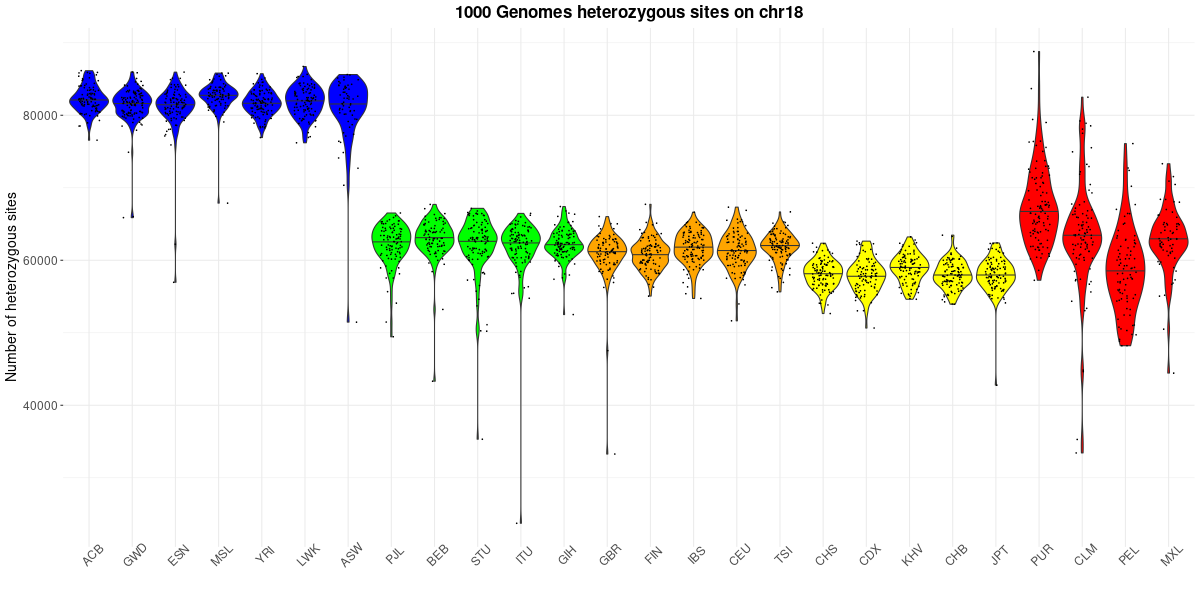
